# Foreword
In this notebook, I explored a dataset from the Florida Fish and Wildlife Conservation Commission, logging Florida Panther Mortality. Formerly a critically endangered species, their numbers have since recovered. 

## Charts
### When Panthers Die
#### By year
https://www.datawrapper.de/_/PnuSi/
#### By month
https://www.datawrapper.de/_/05T7R/

### How Panthers die
https://www.datawrapper.de/_/1Dldc/

### Where Panthers Die
https://www.datawrapper.de/_/pIBa9/



# On the notebook

Toward the end of the notebook, there are some cells that have a lot of output. That is solely to export the data for visualization.

In [275]:
#### Load python tools
%load_ext lab_black
# !pip install geopandas
import pandas as pd
import geopandas as gpd
import shapely.geometry
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


Import data

In [250]:
# https://geodata.floridagio.gov/datasets/myfwc::florida-panther-mortality/about
df = gpd.read_file("./data/Florida_Panther_Mortality.geojson")

In [251]:
# Examine the data and cols
df.head(1)

,OBJECTID,PANTHERID,SEX,AGE,LOCATION,CAUSE,YEAR,Date,last_edited_date,CauseLong,PANTHERID2,MORTID,AGE_UNITS,geometry
0,1740,UCFP422,Female,4,SR29 Chapparal Slough,Vehicular trauma,2022,2022-04-11T04:00:00+00:00,2022-05-02T15:27:17+00:00,Vehicular trauma,,MN-01195,Years,POINT (-81.39091 26.83788)


This data set is from the Florida Fish and Wildlife Conservation Commission. Each row represents a deceased florida panther.

There is no data dictionary so lets do some exploration.

In [252]:
# What data types are we dealing with?
df.dtypes

OBJECTID               int64
PANTHERID             object
SEX                   object
AGE                   object
LOCATION              object
CAUSE                 object
YEAR                   int64
Date                  object
last_edited_date      object
CauseLong             object
PANTHERID2            object
MORTID                object
AGE_UNITS             object
geometry            geometry
dtype: object

In [253]:
# I suspect Age should be a number. What values does it have?
df["AGE"].value_counts().head()

3      56
2.5    56
2      52
4      46
3.5    41
Name: AGE, dtype: int64

In [254]:
# Age looks to be a number. Lets fix that.
# df["AGE"].astype(float)  # FAILS WITH ValueError: could not convert string to float: '2.5-3'

# Looks like this is a string for good reason. I may revist this. Moving on to Date.

In [255]:
# Date looks to be a date
df["Date"] = pd.to_datetime(df["Date"])

In [256]:
# What is the time frame?
print(df["Date"].max())
print(df["Date"].min())
print((df["Date"].max() - df["Date"].min()))
print(18319 / 365)

2022-04-11 04:00:00+00:00
1972-02-13 05:00:00+00:00
18319 days 23:00:00
50.18904109589041


In [257]:
# This looks like mortality data over the last 50 years.
# How many entries are here?
len(df)

608

<AxesSubplot:>

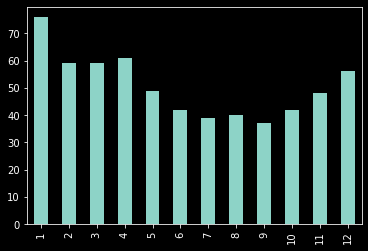

In [258]:
# Is there a specific month that panthers die most?
df["month"] = df["Date"].apply(lambda x: x.month)
panther_death_month = df["month"].value_counts().sort_index()
panther_death_month.plot(kind="bar")

It seems most panther deaths are reported in January, with a dip in frequency during the summer months. I wonder if it's due to patterns in panthers (migration or hunting), or patterns with people (road trips, summer break, vacations)

<AxesSubplot:>

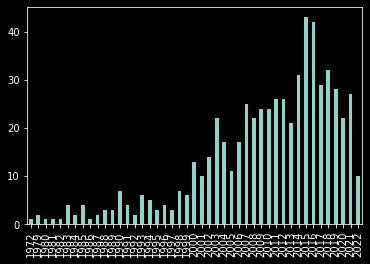

In [309]:
# How about over years?
df["year"] = df["Date"].apply(lambda x: x.year)
panther_death_year = df["year"].value_counts().sort_index()
panther_death_year.plot(kind="bar")

It seems as the species recovered, more were being found dead.

In [259]:
# What about gender?
df.SEX.value_counts(normalize=True)

Male       0.574013
Female     0.407895
Unknown    0.018092
Name: SEX, dtype: float64

Seems to slightly lean male... perhaps an expert can comment on this.

<AxesSubplot:>

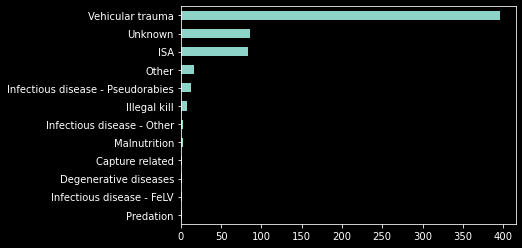

In [260]:
# What is the most common causes of death?
panther_death_cause = df["CauseLong"].value_counts().sort_values()
panther_death_cause.plot(kind="barh")

Looks like the overwhelming majority(?) of deaths are due to vehicles. I want to see this on a map later.

In [261]:
# Is it actually a majority?
df["CauseLong"].value_counts(normalize=True).head(2)

Vehicular trauma    0.651316
Unknown             0.141447
Name: CauseLong, dtype: float64

Yes. It is a majority.

<AxesSubplot:>

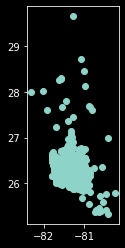

In [262]:
# Lets see the geo
df.plot()

This isn't helpful without a basemap.

Upon opening in QGIS, It's obvious the majority of incidents occur in an area bounded by Cape Coral to the west, Lake Okeechobee to the north and east, and Miami in the south. There are a few locations as north as Gainesville.

Another apparent observation, many entries are on highways, like the western part of Alligator Alley and State Road 29.

In [313]:
# Export to csv for visualization
df.drop("geometry", axis=1).to_csv("./data/processed/panther_data.csv")
df.geometry.to_csv("./data/processed/panther_markers.csv")
panther_death_cause.to_csv("./data/processed/panther_death_cause.csv")
panther_death_month.to_csv("./data/processed/panther_death_month.csv")
panther_death_year.to_csv("./data/processed/panther_death_year.csv")

The point data needs to be binned before visualizing. Hexbin maybe?

In [301]:
# https://james-brennan.github.io/posts/fast_gridding_geopandas/

# total area for the grid
xmin, ymin, xmax, ymax = df.total_bounds
# how many cells across and down
n_cells = 100
cell_size = (xmax - xmin) / n_cells
# projection of the grid
crs = (
    "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
)
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax + cell_size, cell_size):
    for y0 in np.arange(ymin, ymax + cell_size, cell_size):
        # bounds
        x1 = x0 - cell_size
        y1 = y0 + cell_size
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))
cell = gpd.GeoDataFrame(grid_cells, columns=["geometry"], crs=crs)

In [302]:
merged = gpd.sjoin(df, cell, how="left", op="within")

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3191: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/v9/204jm2cs4k9ghhdzc13897gw0000gn/T/ipykernel_53730/3245292534.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 + ...

  merged = gpd.sjoin(df, cell, how="left", op="within")


In [303]:
# make a simple count variable that we can sum
merged["n_panthers"] = 1
# Compute stats per grid cell -- aggregate fires to grid cells with dissolve
dissolve = merged.dissolve(by="index_right", aggfunc="count").drop(columns="geometry")
# put this into cell
cell.loc[dissolve.index, "n_panthers"] = dissolve.n_panthers.values

(-82.10431434460101, -80.31832853593527, 25.138477728025332, 29.88603494093429)

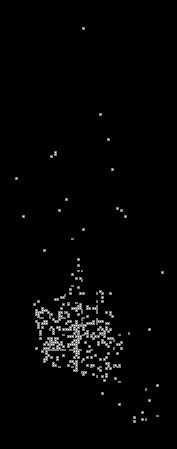

In [304]:
ax = cell.plot(
    column="n_panthers",
    figsize=(12, 8),
    cmap="OrRd",
    vmax=dissolve.n_panthers.max() + 10,
    edgecolor="grey",
)
plt.autoscale(False)
ax.axis("off")

In [305]:
cell.sample(2)

,geometry,n_panthers
3258,"POLYGON ((-82.023 26.937, -82.023 26.957, -82....",NaN
18816,"POLYGON ((-80.523 28.622, -80.523 28.643, -80....",NaN


In [308]:
# Drop empty cells
cell_cleaned = cell.dropna()


print(cell_cleaned.n_panthers.value_counts())

# Split into diffrent CSV for visualization
for n in cell_cleaned.n_panthers.value_counts().keys():

    cell_cleaned[cell_cleaned.n_panthers == n].to_file(
        "./data/processed/panther_cell_value" + str(n) + ".geojson",
        driver="GeoJSON",
    )

1.0     273
2.0      60
3.0      25
4.0      18
5.0       7
6.0       2
8.0       1
10.0      1
Name: n_panthers, dtype: int64


/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with 

In [307]:
# write cells to to disk for visualizing
cell.to_csv("./data/processed/panther_cells.csv")
cell.to_file(
    "./data/processed/panther_cells.json",
    driver="GeoJSON",
)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [272]:
# Add lat/long for datawrapepr
df["lon"] = df["geometry"].x
df["lat"] = df["geometry"].y
df.to_csv("./data/processed/panther.csv")